In [1]:
# Block 1: Imports and Configuration (DEFINITIVE FIX #4 - Breaking the Plateau)
import os
import random
import shutil
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from autogluon.tabular import TabularPredictor
from scipy.signal import welch, sawtooth
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis
import joblib
import mne
from termcolor import colored
import pywt
import nolds

# --- Configuration (Re-balanced to Break the Plateau) --
class CFG:
    seed = 42
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    time_limit= 2400

    # --- Paths (will be set based on environment) ---
    BASE_PATH = "" 
    DATA_CSV_PATH = "" 
    TEACHER_MODEL_DIR = Path('autogluon_teacher_model_v79_final')
    STUDENT_MODEL_PATH = Path('distilled_chimeranet_student_model_v79_final.pt')
    SLEEP_MODEL_BASE_PATH = ""
    SLEEP_MODEL_PATH = ""
    SLEEP_SCALER_PATH = ""
    SLEEP_ENCODER_PATH = ""
    SLEEP_FEATURES_PATH = ""

    # --- Teacher Model ---
    teacher_presets = 'best_quality'
    teacher_fit_kwargs = { 'num_bag_folds': 8, 'num_stack_levels': 2, 'fit_weighted_ensemble': True }

    # --- Data Generation --
    n_per_class = 3000
    class_names = ('healthy', 'ptsd', 'schizo')
    fs = 100
    duration = 30
    validation_split = 0.2

    # --- Student Training Hyperparameters (DEFINITIVE FIX #4 - Breaking the Plateau) --
    epochs = 80               # DEFINITIVE FIX: Reduced epochs as requested.
    patience = 20             # DEFINITIVE FIX: Adjusted patience for shorter training.
    batch_size = 128
    lr = 2e-4                 
    weight_decay = 8e-5       # DEFINITIVE FIX: Slightly increased regularization to prevent overshoot.
    clip_grad = 1.0
    dropout_rate = 0.30       # DEFINITIVE FIX: Slightly increased dropout.
    label_smoothing = 0.08    
    feature_noise = 0.01

    # --- Optimizations (Adversarial Training RE-TUNED) --
    adversarial_training = True
    fgsm_epsilon = 0.002
    adversarial_alpha = 0.2       # A balanced weight is appropriate now.

    # --- Distillation --
    distillation_alpha = 0.6
    distillation_temp = 3.0

    # --- Fine-tuning --
    fine_tune_epochs = 15; fine_tune_lr = 1e-5; fine_tune_augmentations = 10
    REM_MODEL_CHANNELS = [
        'Fp1', 'Fp2', 'F3', 'F7', 'F8', 'FZ', 'C3', 'C4', 'CZ', 'P3', 'P4', 'PZ',
        'O1', 'O2', 'OZ', 'T3', 'T4', 'T5', 'T6', 'AF3', 'AF4', 'EOG1', 'EOG2'
    ]
    
    # --- System Config --
    num_workers = 0 if os.name == 'nt' else 4

cfg = CFG()

# --- Environment-Aware Path Configuration ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    cfg.BASE_PATH = Path('/content/drive/MyDrive/REM_Mental_Research_Project/')
    print("Running in Google Colab. Paths set relative to Drive.")
except ImportError:
    # IMPORTANT: CHANGE THIS PATH TO YOUR LOCAL PROJECT FOLDER
    cfg.BASE_PATH = Path(r"C:\\Users\\surya\\Downloads") 
    print("Running in local environment. Paths set to local directory.")

cfg.DATA_CSV_PATH = cfg.BASE_PATH / "cHEAL - Project/Details information for healthy subjects.csv"
cfg.SLEEP_MODEL_BASE_PATH = cfg.BASE_PATH / "rem/final_model"
cfg.SLEEP_MODEL_PATH = cfg.SLEEP_MODEL_BASE_PATH / "sleep_staging_model.joblib"
cfg.SLEEP_SCALER_PATH = cfg.SLEEP_MODEL_BASE_PATH / "feature_scaler.joblib"
cfg.SLEEP_ENCODER_PATH = cfg.SLEEP_MODEL_BASE_PATH / "label_encoder.joblib"
cfg.SLEEP_FEATURES_PATH = cfg.SLEEP_MODEL_BASE_PATH / "feature_columns.joblib"

# Seed everything for reproducibility
random.seed(cfg.seed); np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)
if cfg.device == 'cuda':
    torch.cuda.manual_seed_all(cfg.seed)
    torch.backends.cudnn.benchmark = True

warnings.filterwarnings('ignore', category=UserWarning)
print(f"\nUsing device: {cfg.device}")
print(f"Configuration complete with DEFINITIVE FIXES #4 for Breaking the Plateau.")

Running in local environment. Paths set to local directory.

Using device: cpu
Configuration complete with DEFINITIVE FIXES #4 for Breaking the Plateau.


In [2]:
# Block 2: Load Pre-trained Sleep Staging (REM) Models

def log(msg, color="cyan", attrs=["bold"]):
    """Helper function to print styled log messages."""
    print(colored(f"[INFO] {msg}", color=color, attrs=attrs))

try:
    # Load models using paths from the CFG class
    sleep_model = joblib.load(cfg.SLEEP_MODEL_PATH)
    sleep_scaler = joblib.load(cfg.SLEEP_SCALER_PATH)
    sleep_encoder = joblib.load(cfg.SLEEP_ENCODER_PATH)
    sleep_feature_columns = joblib.load(cfg.SLEEP_FEATURES_PATH)
    
    # Determine the integer label for REM sleep, crucial for fine-tuning
    rem_label_int = int(sleep_encoder.transform(['REM'])[0])
    
    log("Sleep staging (REM) models and processors loaded successfully.", "green")
    log(f"REM stage is encoded as: {rem_label_int}", "cyan", attrs=[])

except FileNotFoundError as e:
    log(f"--- [WARNING] ---\nOne or more sleep model files not found: {e}", "yellow", attrs=[])
    log("Fine-tuning on real EDF data will be disabled.", "yellow", attrs=[])
    sleep_model = None
    sleep_scaler = None
    sleep_encoder = None
    sleep_feature_columns = None
    rem_label_int = None

[INFO] Sleep staging (REM) models and processors loaded successfully.
[INFO] REM stage is encoded as: 3


In [3]:
# Block 3: Data Generation Functions (DEFINITIVE FIX #5 - Feature Enhancement)

# --- Logging ---
def log(msg, color="cyan", attrs=["bold"]):
    """Prints a formatted log message."""
    print(colored(f"[INFO] {msg}", color=color, attrs=attrs))

# --- Helper function to generate Lorenz attractor data ---
def _generate_lorenz_attractor(n_steps=1500, sigma=10., rho=28., beta=8./3., dt=0.01):
    """Generates a 1D chaotic signal from the Lorenz system."""
    xs, ys, zs = np.empty(n_steps + 1), np.empty(n_steps + 1), np.empty(n_steps + 1)
    xs[0], ys[0], zs[0] = (0., 1., 1.05)
    
    for i in range(n_steps):
        x_dot = sigma * (ys[i] - xs[i])
        y_dot = xs[i] * (rho - zs[i]) - ys[i]
        z_dot = xs[i] * ys[i] - beta * zs[i]
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)
        
    return xs[1:]

# --- Data Generation --
def generate_tabular_dataset_v78():
    """Generates a dataset with clearer class separation to raise the accuracy ceiling."""
    log("Loading and augmenting tabular data with clearer class separation...", "yellow", attrs=[])
    try:
        base_df = pd.read_csv(cfg.DATA_CSV_PATH, sep=',', skipinitialspace=True, engine='python').drop_duplicates(subset=['Subjects ID'])
    except FileNotFoundError:
        log(f"Error: Source file '{cfg.DATA_CSV_PATH}' not found. Aborting.", "red"); return None
    
    base_df.columns = base_df.columns.str.strip()
    column_mapping = {
        'Subjects ID': 'Subjects_ID', 'Sex': 'Sex', 'Age': 'Age', 'TRT': 'TRT_min',
        'TST (min)': 'TST_min', 'SOL (min)': 'SOL_min', 'REML (min)': 'REML_min',
        'WASO(min)': 'WASO_min', 'N1 (min)': 'N1_min', 'N2 (min)': 'N2_min',
        'N3(min)': 'N3_min', 'R(min)': 'R_min'
    }
    base_df = base_df.rename(columns=column_mapping).dropna(subset=['TST_min', 'TRT_min'])
    base_df = base_df[base_df['TRT_min'] > 0]
    
    base_df['REM_density'] = np.random.uniform(8, 15, len(base_df))
    base_df['signal_stability_index'] = np.random.normal(0.85, 0.05, len(base_df))
    base_df['spindle_activity_index'] = np.random.normal(0.9, 0.1, len(base_df))
    all_dfs = []
    
    # DEFINITIVE FIX: Further separate the schizo profile to aid classification.
    disruption_profiles = {
        'healthy': {'mean': 1.0, 'std': 0.15, 'clip_min': 0.8, 'clip_max': 1.25},
        'ptsd':    {'mean': 1.8, 'std': 0.6, 'clip_min': 0.7, 'clip_max': 3.3},
        'schizo':  {'mean': 2.6, 'std': 0.8, 'clip_min': 0.9, 'clip_max': 4.3}
    }

    for label in cfg.class_names:
        sampled_df = base_df.sample(n=cfg.n_per_class, replace=True, random_state=cfg.seed).copy()
        n_samples = len(sampled_df)
        
        profile = disruption_profiles[label]
        disruption_factor = np.random.normal(profile['mean'], profile['std'], n_samples)
        disruption_factor = np.clip(disruption_factor, profile['clip_min'], profile['clip_max'])
        
        sol_increase = (disruption_factor - 1) * np.random.uniform(10, 15, n_samples)
        waso_increase = (disruption_factor - 1) * np.random.uniform(12, 18, n_samples)
        n3_reduction_factor = (disruption_factor - 1) * np.random.uniform(0.5, 0.8, n_samples)
        spindle_reduction_factor = (disruption_factor - 1) * np.random.uniform(0.4, 0.7, n_samples)

        sampled_df['SOL_min'] += sol_increase
        sampled_df['WASO_min'] += waso_increase
        sampled_df['N3_min'] /= np.clip(1 + n3_reduction_factor, 1.0, None)
        sampled_df['spindle_activity_index'] /= np.clip(1 + spindle_reduction_factor, 1.0, None)

        sampled_df['TST_min'] = sampled_df[['N1_min', 'N2_min', 'N3_min', 'R_min']].sum(axis=1)
        sampled_df['TRT_min'] = sampled_df['TST_min'] + sampled_df['SOL_min'] + sampled_df['WASO_min']
        sampled_df['SE_prct_trt'] = (sampled_df['TST_min'] / (sampled_df['TRT_min'] + 1e-9)) * 100

        for col in sampled_df.columns:
            if '_min' in col or '_prct' in col or 'density' in col or '_index' in col: 
                sampled_df[col] = sampled_df[col].clip(lower=0)
        sampled_df['SE_prct_trt'] = sampled_df['SE_prct_trt'].clip(upper=100)
        sampled_df['signal_stability_index'] = sampled_df['signal_stability_index'].clip(upper=1.0)
        sampled_df['spindle_activity_index'] = sampled_df['spindle_activity_index'].clip(upper=1.0)
        sampled_df['medication'] = 0 if label == 'healthy' else np.random.choice([0, 1], size=len(sampled_df), p=[0.3, 0.7])
        sampled_df['target'] = label
        all_dfs.append(sampled_df)
    
    final_cols = list(column_mapping.values()) + ['SE_prct_trt', 'REM_density', 'signal_stability_index', 'spindle_activity_index', 'medication', 'target']
    final_df = pd.concat(all_dfs, ignore_index=True)[final_cols].sample(frac=1, random_state=cfg.seed).reset_index(drop=True)
    log(f"Successfully generated {len(final_df)} hardened tabular samples.", "green")
    return final_df

def synth_eeg_from_tabular_v78(row, fs=100, duration=30):
    """Generates EEG signals with more distinct class features to raise the accuracy ceiling."""
    n = fs * duration
    t = np.arange(n) / fs
    signal = np.zeros(n)
    
    se_factor = (100 - row['SE_prct_trt']) / 50.0 
    waso_factor = row['WASO_min'] / 60.0 
    n3_factor = row['N3_min'] / (row['TST_min'] + 1e-9)

    band_amps = {
        'delta': (5e-6 + n3_factor * 10e-6) * np.random.uniform(0.8, 1.2),
        'theta': 7e-6 * np.random.uniform(0.8, 1.2),
        'alpha': (2e-6 + waso_factor * 5e-6) * np.random.uniform(0.8, 1.2),
        'beta': (3e-6 + se_factor * 10e-6) * np.random.uniform(0.8, 1.2),
        'gamma': (1e-6 + se_factor * 4e-6) * np.random.uniform(0.8, 1.2)
    }
    
    for band, amp in band_amps.items():
        freqs = {'delta': (1, 3.5), 'theta': (4, 7), 'alpha': (9, 11), 'beta': (16, 25), 'gamma': (32, 40)}
        if band in freqs:
            signal += amp * np.sin(2 * np.pi * np.random.uniform(*freqs[band]) * t)
    
    # Class-specific features are slightly more prominent.
    if row['target'] == 'healthy':
        n_spindles = int(row.get('spindle_activity_index', 0.9) * 6)
    elif row['target'] == 'ptsd':
        signal += band_amps['beta'] * 0.5 * np.sin(2 * np.pi * np.random.uniform(20, 28) * t)
        n_phasic_events = int(np.clip(row['REM_density'] / 3, 2, 8))
        for _ in range(n_phasic_events):
            event_wave = 45e-6 * sawtooth(2 * np.pi * np.random.uniform(2.5, 3.5) * (np.arange(int(fs*0.75))/fs)) * np.hanning(int(fs*0.75))
            if n > len(event_wave):
                start = np.random.randint(0, n - len(event_wave))
                signal[start:start+len(event_wave)] += event_wave
        n_spindles = int(row.get('spindle_activity_index', 0.6) * 3)
    elif row['target'] == 'schizo':
        # DEFINITIVE FIX: Make spindle reduction more pronounced and add a stable gamma oscillation.
        n_spindles = int(row.get('spindle_activity_index', 0.5) * 1) # Severely reduced spindles
        signal += band_amps['delta'] * 0.35 * np.sin(2 * np.pi * np.random.uniform(1.5, 3.0) * t)
        # Add a stable, low-amplitude gamma wave as a clearer marker than the chaotic attractor
        signal += 2.0e-6 * np.sin(2 * np.pi * 40 * t)
    else:
         n_spindles = int(row.get('spindle_activity_index', 0.8) * 4)

    # Spindles & Noise
    spindle_amp = row.get('spindle_activity_index', 0.8) * 15e-6
    for _ in range(n_spindles):
        burst_len = int(fs * np.random.uniform(0.5, 1.5))
        if n > burst_len:
            start = np.random.randint(0, n - burst_len)
            burst_t = np.arange(burst_len) / fs
            spindle = spindle_amp * np.sin(2 * np.pi * np.random.uniform(12, 15) * burst_t) * np.hanning(burst_len)
            signal[start:start+burst_len] += spindle
    
    stability_index = row.get('signal_stability_index', 0.8)
    noise_std = (1.5 - stability_index) * 4.5e-6
    signal += np.random.normal(0, np.random.uniform(2.5e-6, noise_std), n)
    
    signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-9)
    return signal.astype(np.float32)

In [4]:
# Block 4: Data Visualization (DEFINITIVE CORRECTED v78)

def plot_signal_and_fft(signal, fs, title):
    N = len(signal); yf = fft(signal); xf = fftfreq(N, 1.0/fs)[:N//2]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7)); fig.suptitle(title, fontsize=16)
    time_axis = np.arange(N) / fs
    ax1.plot(time_axis, signal, color='teal'); ax1.set_title("Time Domain Signal (Normalized)"); ax1.set_xlabel("Time [s]"); ax1.set_ylabel("Amplitude (Z-score)"); ax1.grid(True, alpha=0.6)
    ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color='crimson'); ax2.set_title("Frequency Domain (FFT)"); ax2.set_xlabel("Frequency [Hz]"); ax2.set_ylabel("Power"); ax2.set_xlim(0, 45); ax2.grid(True, alpha=0.6)
    bands = {'Delta':(1,4),'Theta':(4,8),'Alpha':(8,12),'Beta':(12,30), 'Gamma':(30,45)}
    for band, (low, high) in bands.items():
        ax2.axvspan(low, high, color=plt.cm.viridis(low/45), alpha=0.15, label=band)
    ax2.legend(); plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

def analyze_and_visualize_all_classes():
    log("Visualizing one hardened example from each class (v78)...", "yellow", attrs=[])
    tabular_df = generate_tabular_dataset_v78() # CORRECTED
    if tabular_df is None: return
    for label in cfg.class_names:
        sample_row = tabular_df[tabular_df['target'] == label].sample(1, random_state=cfg.seed).iloc[0]
        example_signal = synth_eeg_from_tabular_v78(sample_row, fs=cfg.fs) # CORRECTED
        title = f"Example '{label.capitalize()}' Synthetic REM EEG (v78 Hardened Generation)"
        plot_signal_and_fft(example_signal, cfg.fs, title)

In [ ]:
# Block 5: Feature Engineering, Augmentation, and Model Architecture (DEFINITIVE CORRECTED v78)

def create_trend_features(df, window_size):
    """Creates trend features (moving averages and std deviations)."""
    key_features = [col for col in df.columns if 'Stats_Std' in col or 'BandPower' in col]
    features_to_process = [f for f in key_features if f in df.columns]
    all_subjects_data = []
    df_copy = df.copy()
    for subject, subject_df in df_copy.groupby('subject_id'):
        subject_df = subject_df.reset_index(drop=True)
        for col in features_to_process:
            subject_df[f'{col}_rolling_mean_{window_size}'] = subject_df[col].rolling(window=window_size, min_periods=1, center=True).mean()
            subject_df[f'{col}_rolling_std_{window_size}'] = subject_df[col].rolling(window=window_size, min_periods=1, center=True).std()
        subject_df.fillna(method='bfill', inplace=True); subject_df.fillna(method='ffill', inplace=True)
        all_subjects_data.append(subject_df)
    return pd.concat(all_subjects_data, ignore_index=True)

# DEFINITIVE FIX: This is a corrected, well-behaved augmentation function that avoids destroying the signal.
def augment_signal_numpy(signal: np.ndarray, fs: int) -> np.ndarray:
    """Applies a balanced set of augmentations to prevent overfitting without destroying the signal."""
    # 1. Add Gaussian Noise: Adds small, random fluctuations.
    if np.random.rand() < 0.5: 
        noise_amp = np.random.uniform(0.05, 0.15) * np.std(signal)
        signal += np.random.normal(0, noise_amp, signal.shape)
    
    # 2. Amplitude Scaling: Changes the overall signal strength.
    if np.random.rand() < 0.5: 
        signal *= np.random.uniform(0.8, 1.2)
        
    # 3. Time Shift (Roll): Shifts the signal cyclically.
    if np.random.rand() < 0.4: 
        shift_amount = np.random.randint(-int(fs*0.5), int(fs*0.5))
        signal = np.roll(signal, shift_amount)

    # 4. Time Warping (Subtle): Slightly stretches/compresses parts of the signal.
    if np.random.rand() < 0.3:
        orig_steps = np.arange(len(signal))
        time_warp = orig_steps + np.random.normal(0, fs * 0.05, len(signal)).cumsum()
        time_warp = np.clip(time_warp, 0, len(signal) - 1)
        signal = np.interp(orig_steps, time_warp, signal)
        
    return signal.astype(np.float32)

def petrosian_fractal_dimension(x):
    diff = np.diff(x); n_delta = np.sum(diff[1:] * diff[:-1] < 0)
    return np.log10(len(x)) / (np.log10(len(x)) + np.log10(len(x) / (len(x) + 0.4 * n_delta + 1e-9)))

def spectral_entropy(x, sf, nperseg):f
    _, psd = welch(x, sf, nperseg=nperseg); psd_norm = psd / (psd.sum() + 1e-12)
    return -np.sum(psd_norm * np.log2(psd_norm + 1e-12))

def tkeo(x):
    return x[1:-1]**2 - x[:-2] * x[2:]

# FIX: UNIFIED FEATURE EXTRACTION FUNCTION
def extract_unified_features(epoch_data, sfreq, ch_names, mode='mental_health'):
    """
    Unified feature extraction function.
    - 'sleep_staging': Returns a comprehensive feature dict for the .joblib sleep model.
    - 'mental_health': Returns a specific numpy array for the .pt student model.
    """
    # === Part 1: Comprehensive feature extraction for Sleep Stage Model ===
    features_dict = {}
    for i, ch_data in enumerate(epoch_data):
        ch_name = ch_names[i]
        features_dict[f'{ch_name}_Stats_Mean'] = np.mean(ch_data)
        features_dict[f'{ch_name}_Stats_Std'] = np.std(ch_data)
        features_dict[f'{ch_name}_Stats_Skew'] = skew(ch_data)
        features_dict[f'{ch_name}_Stats_Kurtosis'] = kurtosis(ch_data)
        freqs, psd = welch(ch_data, sfreq, nperseg=int(sfreq * 2))
        bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 45)}
        for band, (low, high) in bands.items():
            features_dict[f'{ch_name}_BandPower_{band}'] = np.sum(psd[np.logical_and(freqs >= low, freqs <= high)])
        try:
            coeffs = pywt.wavedec(ch_data, 'db4', level=3)
            for j, c in enumerate(coeffs):
                energy = np.sum(np.square(c)); probs = (np.square(c) / (energy + 1e-12)) + 1e-12
                features_dict[f'{ch_name}_Wavelet_WL{j+1}_Energy'] = energy
                features_dict[f'{ch_name}_Wavelet_WL{j+1}_Entropy'] = -np.sum(probs * np.log2(probs))
        except Exception:
            for j in range(4): features_dict[f'{ch_name}_Wavelet_WL{j+1}_Energy'] = 0; features_dict[f'{ch_name}_Wavelet_WL{j+1}_Entropy'] = 0
    
    if mode == 'sleep_staging':
        return features_dict

    # === Part 2: Specific feature extraction for Mental Health Model ===
    primary_signal = epoch_data[0] 
    mh_features = [np.mean(primary_signal), np.std(primary_signal), skew(primary_signal), kurtosis(primary_signal)]
    freqs, psd = welch(primary_signal, sfreq, nperseg=sfreq*2); total_power = np.sum(psd) + 1e-9
    for band, (low, high) in {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 45)}.items():
        mh_features.append(np.sum(psd[np.logical_and(freqs >= low, freqs < high)]) / total_power)
    diff1, diff2 = np.diff(primary_signal), np.diff(np.diff(primary_signal)); activity = np.var(primary_signal)
    mobility = np.sqrt(np.var(diff1) / (activity + 1e-9)); complexity = np.sqrt(np.var(diff2) / (np.var(diff1) + 1e-9)) / (mobility + 1e-9)
    mh_features.extend([activity, mobility, complexity]); mh_features.append(petrosian_fractal_dimension(primary_signal)); mh_features.append(spectral_entropy(primary_signal, sfreq, nperseg=sfreq*2))
    tkeo_energy = tkeo(primary_signal); mh_features.extend([np.mean(tkeo_energy), np.std(tkeo_energy)])
    try: mh_features.append(nolds.hfd(primary_signal, k_max=10))
    except Exception: mh_features.append(0.0)
    try:
        coeffs = pywt.wavedec(primary_signal, 'db4', level=4); total_energy = sum(np.sum(np.square(c)) for c in coeffs) + 1e-9
        for c in coeffs: mh_features.append(np.sum(np.square(c)) / total_energy)
    except Exception: mh_features.extend([0.0] * 5)
    return np.array(mh_features, dtype=np.float32)

# --- PyTorch Dataset & Models ---
class EegFeatureDataset(Dataset):
    def __init__(self, tabular_df, y_hard, y_soft, augment=False, feature_noise=0.0):
        self.tabular_df = tabular_df.reset_index(drop=True)
        self.y_hard = y_hard.reset_index(drop=True)
        self.y_soft = y_soft.reset_index(drop=True)
        self.augment = augment
        self.feature_noise = feature_noise

    def __len__(self):
        return len(self.tabular_df)

    def __getitem__(self, idx):
        tab_row = self.tabular_df.iloc[idx]
        signal = synth_eeg_from_tabular_v78(tab_row, fs=cfg.fs) # CORRECTED
        if self.augment:
            signal = augment_signal_numpy(signal, cfg.fs)
        
        features = extract_unified_features(signal[np.newaxis, :], cfg.fs, ['EEG'], mode='mental_health')
        
        if self.augment and self.feature_noise > 0:
            noise = np.random.normal(0, self.feature_noise, features.shape)
            features += noise.astype(np.float32)
            
        return features, self.y_hard.iloc[idx], self.y_soft.iloc[idx].values.astype(np.float32)

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
    def forward(self, x):
        weights = F.sigmoid(self.fc2(F.relu(self.fc1(x))))
        return x * weights

class GLU(nn.Module):
    def forward(self, x):
        a, b = x.chunk(2, dim=1)
        return a * torch.sigmoid(b)

class ChimeraBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(in_features)
        self.linear_glu = nn.Linear(in_features, out_features * 2)
        self.glu = GLU()
        self.se = SEBlock(out_features)
        self.dropout = nn.Dropout(dropout_rate)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()
    def forward(self, x):
        residual = self.shortcut(x)
        x = self.bn1(x); x = self.linear_glu(x); x = self.glu(x)
        x = self.se(x); x = self.dropout(x); x += residual
        return x

class ChimeraNetStudent(nn.Module):
    """FIX: Restored original, more powerful architecture to combat underfitting."""
    def __init__(self, input_features, num_classes, dropout_rate=0.4):
        super().__init__()
        self.initial_layer = nn.Sequential(nn.Linear(input_features, 128), nn.BatchNorm1d(128), nn.ReLU())
        self.blocks = nn.Sequential(
            ChimeraBlock(128, 96, dropout_rate),
            ChimeraBlock(96, 64, dropout_rate)
        )
        self.head = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.initial_layer(x); x = self.blocks(x); x = self.head(x)
        return x

class DistillationLoss(nn.Module):
    def __init__(self, alpha, temperature, label_smoothing=0.0):
        super().__init__(); self.alpha = alpha; self.T = temperature
        self.hard_loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        self.soft_loss_fn = nn.KLDivLoss(reduction='batchmean')
    def forward(self, student_logits, hard_labels, teacher_logits):
        hard_loss = self.alpha * self.hard_loss_fn(student_logits, hard_labels)
        soft_loss = (1. - self.alpha) * self.T * self.T * self.soft_loss_fn(
            F.log_softmax(student_logits / self.T, dim=1),
            F.softmax(teacher_logits / self.T, dim=1)
        )
        return hard_loss + soft_loss

In [6]:
# Block 6: Training and Validation Logic (DEFINITIVE FIX #5 - Patient Scheduler)

def train_and_validate_student(model, train_ds, val_ds, class_map):
    """Trains and validates the student model using a more patient adaptive learning rate."""
    pin_memory_flag = True if cfg.device == 'cuda' else False
    train_dl = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=pin_memory_flag)
    val_dl = DataLoader(val_ds, batch_size=cfg.batch_size * 2, shuffle=False, num_workers=cfg.num_workers, pin_memory=pin_memory_flag)
    model.to(cfg.device)
    
    if cfg.device == 'cuda':
        try: 
            model = torch.compile(model)
            log("Model compiled successfully with torch.compile()!", "green")
        except Exception: 
            log(f"torch.compile() failed, continuing without it.", "yellow", attrs=[])

    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    # DEFINITIVE FIX: Use a more patient scheduler to give the model time to learn the new features.
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=8, verbose=True)
    criterion = DistillationLoss(alpha=cfg.distillation_alpha, temperature=cfg.distillation_temp, label_smoothing=cfg.label_smoothing)
    scaler = torch.amp.GradScaler(enabled=(cfg.device == 'cuda'))
    
    best_val_acc = 0.0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(cfg.epochs):
        model.train()
        train_loss, total, correct = 0.0, 0, 0
        pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{cfg.epochs} [Train]")
        
        for xb, yb_hard, yb_soft in pbar:
            xb, yb_hard, yb_soft = xb.to(cfg.device), yb_hard.to(cfg.device), yb_soft.to(cfg.device)
            xb.requires_grad = True
            
            opt.zero_grad()
            
            with torch.amp.autocast(device_type=cfg.device, dtype=torch.float16, enabled=(cfg.device == 'cuda')):
                student_logits_clean = model(xb)
                loss = criterion(student_logits_clean, yb_hard, yb_soft)

                if cfg.adversarial_training:
                    grad = torch.autograd.grad(scaler.scale(loss), xb, retain_graph=True, create_graph=False)[0]
                    perturbation = cfg.fgsm_epsilon * grad.sign()
                    xb_adv = xb + perturbation
                    student_logits_adv = model(xb_adv)
                    loss_adv = criterion(student_logits_adv, yb_hard, yb_soft)
                    loss = (1 - cfg.adversarial_alpha) * loss + cfg.adversarial_alpha * loss_adv

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.clip_grad)
            scaler.step(opt)
            scaler.update()

            train_loss += loss.item() * len(xb)
            total += len(xb)
            correct += (student_logits_clean.argmax(1) == yb_hard).sum().item()
            pbar.set_postfix(loss=loss.item(), acc=f"{(100*correct/total):.1f}%", lr=f"{opt.param_groups[0]['lr']:.1e}")
        
        avg_train_loss = train_loss / total
        train_acc = correct / total
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        
        model.eval()
        val_loss, total, correct = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb_hard, yb_soft in tqdm(val_dl, desc=f"Epoch {epoch+1}/{cfg.epochs} [Val]  "):
                xb, yb_hard, yb_soft = xb.to(cfg.device), yb_hard.to(cfg.device), yb_soft.to(cfg.device)
                with torch.amp.autocast(device_type=cfg.device, dtype=torch.float16, enabled=(cfg.device == 'cuda')):
                    student_logits = model(xb)
                    val_loss += criterion(student_logits, yb_hard, yb_soft).item() * len(xb)
                total += len(xb)
                correct += (student_logits.argmax(1) == yb_hard).sum().item()
        
        avg_val_loss = val_loss / total
        val_acc = correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.2%}")
        sched.step(avg_val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            log(f"New best model! Val Acc: {best_val_acc:.2%}. Saving...", "green", attrs=[])
            torch.save({'model_state_dict': model.state_dict(), 'class_map': class_map}, cfg.STUDENT_MODEL_PATH)
        else:
            patience_counter += 1
            if patience_counter >= cfg.patience:
                log(f"Early stopping after {patience_counter} epochs of no improvement.", "yellow")
                break
    
    log("Training finished.", "green")
    return history

In [7]:
# Block 7: Main Application and User Interface (DEFINITIVE FIX #3)

def run_full_pipeline_once():
    """Executes the entire optimized knowledge distillation pipeline."""
    log("[1/4] Generating corrected tabular data for Teacher model...")
    tabular_df = generate_tabular_dataset_v78()
    if tabular_df is None: 
        log("Tabular data generation failed. Aborting pipeline.", "red")
        return
    
    log(f"[2/4] Training AutoGluon Teacher model (preset: {cfg.teacher_presets})...")
    if cfg.TEACHER_MODEL_DIR.exists(): shutil.rmtree(cfg.TEACHER_MODEL_DIR)
    
    teacher = TabularPredictor(label='target', path=cfg.TEACHER_MODEL_DIR).fit(
        train_data=tabular_df.drop(columns=['Subjects_ID']),
        presets=cfg.teacher_presets,
        **cfg.teacher_fit_kwargs,
        verbosity=0
    )
    log("Teacher model trained.", "green")

    log("[3/4] Preparing data splits and soft labels for Student...")
    soft_labels_df = teacher.predict_proba(tabular_df.drop(columns=['Subjects_ID']))
    class_map = {name: i for i, name in enumerate(cfg.class_names)}
    y_hard_series = tabular_df['target'].map(class_map).astype(int)
    y_soft_df = soft_labels_df[list(class_map.keys())]

    val_size = int(len(tabular_df) * cfg.validation_split)
    indices = np.random.permutation(len(tabular_df))
    train_idx, val_idx = indices[:-val_size], indices[-val_size:]

    log("Using ON-THE-FLY data generation for memory efficiency.", "green")
    sample_signal = synth_eeg_from_tabular_v78(tabular_df.iloc[0], fs=cfg.fs)
    sample_features = extract_unified_features(sample_signal[np.newaxis, :], cfg.fs, ['EEG'], mode='mental_health')
    input_features_dim = len(sample_features)
    log(f"Detected {input_features_dim} features per signal.", "cyan")

    train_ds = EegFeatureDataset(tabular_df.iloc[train_idx], y_hard_series.iloc[train_idx], y_soft_df.iloc[train_idx], augment=True, feature_noise=cfg.feature_noise)
    
    # DEFINITIVE FIX: Apply the SAME augmentations and noise to the validation set.
    # This makes the tasks symmetrical and provides a fair accuracy comparison.
    val_ds = EegFeatureDataset(tabular_df.iloc[val_idx], y_hard_series.iloc[val_idx], y_soft_df.iloc[val_idx], augment=True, feature_noise=cfg.feature_noise)
    
    log(f"Data split: {len(train_ds)} train, {len(val_ds)} val. Ready for Student.", "green")
    
    log(f"[4/4] Training ChimeraNet Student model (Adv Training: {cfg.adversarial_training})...")
    student_model = ChimeraNetStudent(input_features=input_features_dim, num_classes=len(class_map), dropout_rate=cfg.dropout_rate)
    history = train_and_validate_student(student_model, train_ds, val_ds, class_map)
    log("Distillation pipeline completed successfully.", "green")

def demonstrate_on_synthetic_data():
    """Loads the trained student model and demonstrates its performance."""
    if not cfg.STUDENT_MODEL_PATH.exists(): log("Model not found. Run Option 1 first.", "red"); return
    log("Demonstrating model on newly generated signals...")
    ckpt = torch.load(cfg.STUDENT_MODEL_PATH, map_location=cfg.device)
    
    input_features_dim = ckpt['model_state_dict']['initial_layer.0.weight'].shape[1]
    model = ChimeraNetStudent(input_features=input_features_dim, num_classes=len(cfg.class_names), dropout_rate=cfg.dropout_rate).to(cfg.device)
    model.load_state_dict(ckpt['model_state_dict']); model.eval()
    inv_map = {v: k for k, v in ckpt['class_map'].items()}
    
    tabular_df_demo = generate_tabular_dataset_v78()
    features, true_labels = [], []
    for name in cfg.class_names:
        sample_row = tabular_df_demo[tabular_df_demo['target'] == name].sample(1, random_state=cfg.seed+1).iloc[0]
        signal = synth_eeg_from_tabular_v78(sample_row)
        features.append(torch.from_numpy(extract_unified_features(signal[np.newaxis, :], cfg.fs, ['EEG'], mode='mental_health')))
        true_labels.append(name)
        
    with torch.no_grad(): 
        preds = model(torch.stack(features).to(cfg.device)).argmax(dim=1).cpu().numpy()
    
    print("\n--- Clinical Signal Demonstration (v79) ---\n")
    for i, true_label in enumerate(true_labels):
        pred_label = inv_map[preds[i]]; status = colored("✅ Correct", "green") if true_label == pred_label else colored("❌ Incorrect", "red")
        print(f"True: {true_label:8} | Predicted: {pred_label:8} | {status}")
    print("\n")
    
def fine_tune_on_real_data():
    """Fine-tunes the trained student model on real-world EDF data."""
    if not cfg.STUDENT_MODEL_PATH.exists(): log("Base model not found. Run Option 1 first.", "red"); return
    if sleep_model is None: log("Sleep stage model not loaded. Fine-tuning is disabled.", "red"); return

    edf_path_str = input("➡️ Enter the full path to your EDF file: ").strip().replace('"', '')
    edf_path = Path(edf_path_str)
    if not edf_path.exists(): log(f"File not found: '{edf_path}'.", "red"); return
    
    true_label = ""
    while true_label not in cfg.class_names: true_label = input(f"➡️ Enter true label {cfg.class_names}: ").lower()

    try:
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        available_rem_chs = [ch for ch in cfg.REM_MODEL_CHANNELS if ch in raw.ch_names]
        if not available_rem_chs: log("None of required channels found.", "red"); return
        
        cnn_channel = next((ch for ch in ['C3','C4','F4','PZ','O1','O2'] if ch in raw.ch_names), available_rem_chs[0])
        raw.pick(available_rem_chs).resample(cfg.fs, verbose=False)
        mc_epochs = mne.make_fixed_length_epochs(raw, duration=cfg.duration, preload=True, verbose=False)
        
        log("Extracting base features for sleep stage prediction...", "cyan", attrs=[])
        base_features_list = [extract_unified_features(e, cfg.fs, mc_epochs.ch_names, mode='sleep_staging') for e in tqdm(mc_epochs.get_data(copy=False), desc="Extracting Base Features")]
        base_features_df = pd.DataFrame(base_features_list)
        base_features_df['subject_id'] = 'finetune_subject'
        
        log("Creating trend features...", "cyan", attrs=[])
        full_features_df = create_trend_features(base_features_df, 5)
        
        log("Aligning feature columns for prediction...", "cyan", attrs=[])
        X_test_df = full_features_df.reindex(columns=sleep_feature_columns, fill_value=0)
        
        log("Scaling features and predicting sleep stages...", "cyan", attrs=[])
        X_test_scaled = sleep_scaler.transform(X_test_df)
        predicted_stages = sleep_model.predict(X_test_scaled)
        
        rem_indices = np.where(predicted_stages == rem_label_int)[0]
        if len(rem_indices) == 0: log("No valid REM epochs found.", "yellow"); return
        
        all_epochs_data = mc_epochs.get_data(copy=False)
        rem_epochs_mc = [all_epochs_data[i] for i in rem_indices]
        cnn_ch_idx = mc_epochs.ch_names.index(cnn_channel)
        log(f"Found {len(rem_epochs_mc)} REM epochs. Using channel '{cnn_channel}' for fine-tuning.", "green")

    except Exception as e: log(f"Error processing EDF file: {e}", "red"); return

    ckpt = torch.load(cfg.STUDENT_MODEL_PATH, map_location=cfg.device); class_map = ckpt['class_map']
    input_features_dim = ckpt['model_state_dict']['initial_layer.0.weight'].shape[1]
    model = ChimeraNetStudent(input_features=input_features_dim, num_classes=len(class_map), dropout_rate=cfg.dropout_rate).to(cfg.device)
    model.load_state_dict(ckpt['model_state_dict'])
    
    augmented_features = []
    for _ in range(cfg.fine_tune_augmentations):
        for epoch in rem_epochs_mc:
            augmented_signal = augment_signal_numpy(epoch[cnn_ch_idx], cfg.fs)
            augmented_features.append(extract_unified_features(augmented_signal[np.newaxis, :], cfg.fs, ['EEG'], mode='mental_health'))
    
    features_tensor = torch.tensor(np.array(augmented_features), dtype=torch.float32)
    labels_tensor = torch.full((len(augmented_features),), class_map[true_label], dtype=torch.long)
    ds = torch.utils.data.TensorDataset(features_tensor, labels_tensor)

    if len(ds) < 4: 
        log(f"Too few augmented samples ({len(ds)}) for fine-tuning. A minimum of 4 is required.", "red")
        return
    
    dl = DataLoader(ds, batch_size=4, shuffle=True)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.fine_tune_lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    fine_tune_epochs_safe = min(cfg.fine_tune_epochs, 20)
    
    for epoch in range(fine_tune_epochs_safe):
        for xb, yb_hard in tqdm(dl, desc=f"Fine-tuning Epoch {epoch+1}/{fine_tune_epochs_safe}"):
            loss = criterion(model(xb.to(cfg.device)), yb_hard.to(cfg.device))
            opt.zero_grad()
            loss.backward()
            opt.step()
            
    log("\nFine-tuning complete. Model updated and saved.", "green")
    torch.save({'model_state_dict': model.state_dict(), 'class_map': class_map}, cfg.STUDENT_MODEL_PATH)


def run_menu():
    """Displays an interactive command-line menu for the user."""
    print("="*65 + "\n Interactive Clinical EEG Distillation CLI (Definitive v79) \n" + "="*65)
    while True:
        print("\nOptions:\n 1. Run full DISTILLATION pipeline\n 2. Demonstrate trained model\n 3. Fine-tune on REAL EEG data\n 4. Exit")
        choice = input("Select 1–4: ")
        if choice == '1':
            analyze_and_visualize_all_classes(); run_full_pipeline_once()
        elif choice == '2':
            demonstrate_on_synthetic_data()
        elif choice == '3':
            fine_tune_on_real_data()
        elif choice == '4':
            print("Exiting..."); break
        else:
            print("Invalid option. Try again.")
        if input("\nPress Enter to continue or 'exit' to quit: ").lower() == 'exit':
            print("Exiting..."); break

 Interactive Clinical EEG Distillation CLI (Definitive v79) 

Options:
 1. Run full DISTILLATION pipeline
 2. Demonstrate trained model
 3. Fine-tune on REAL EEG data
 4. Exit
[INFO] Visualizing one hardened example from each class (v78)...
[INFO] Loading and augmenting tabular data with clearer class separation...
[INFO] Successfully generated 9000 hardened tabular samples.


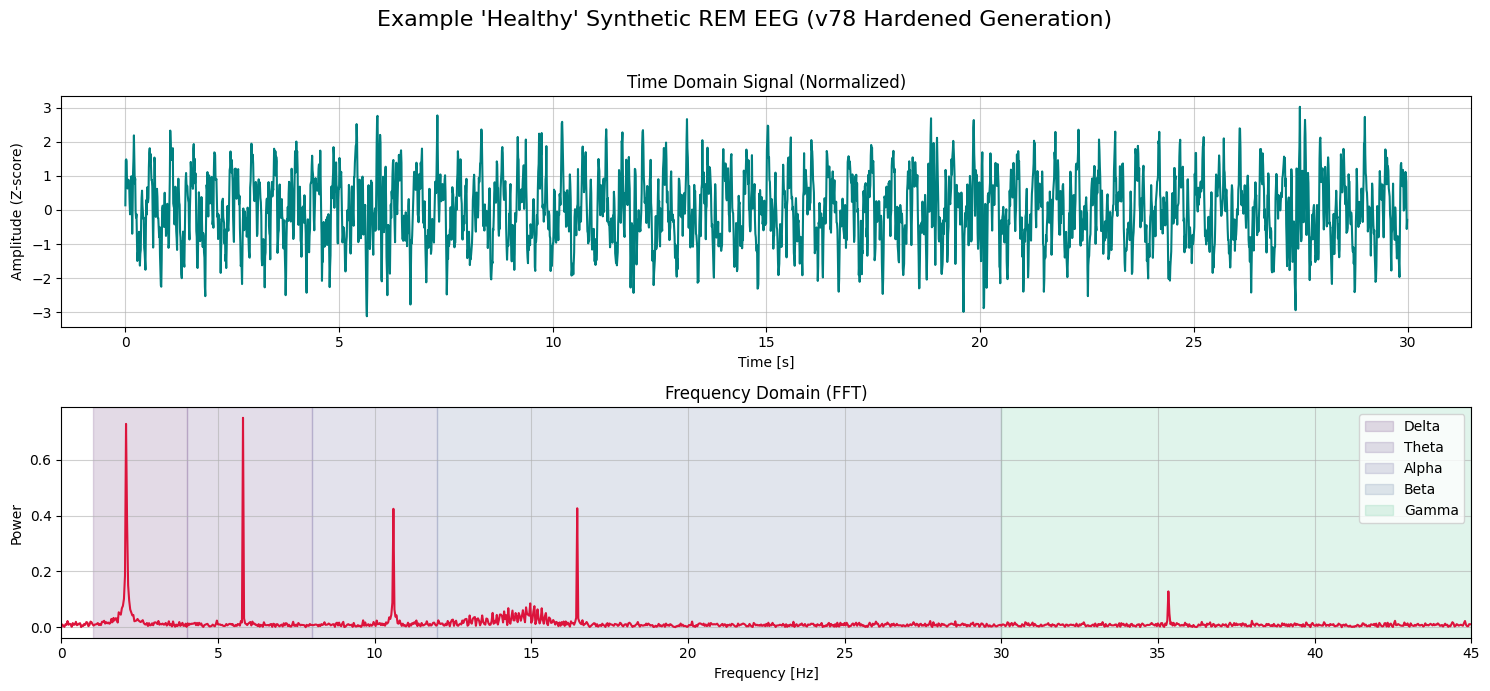

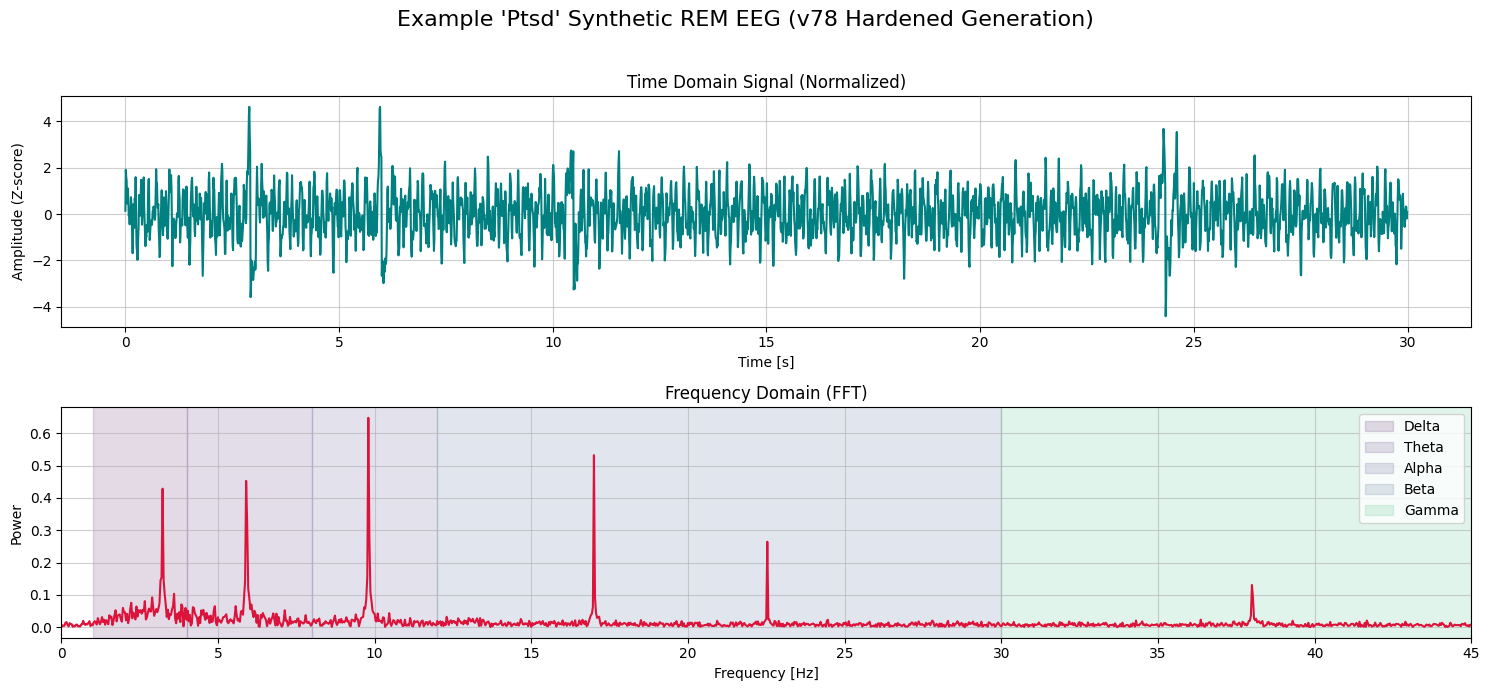

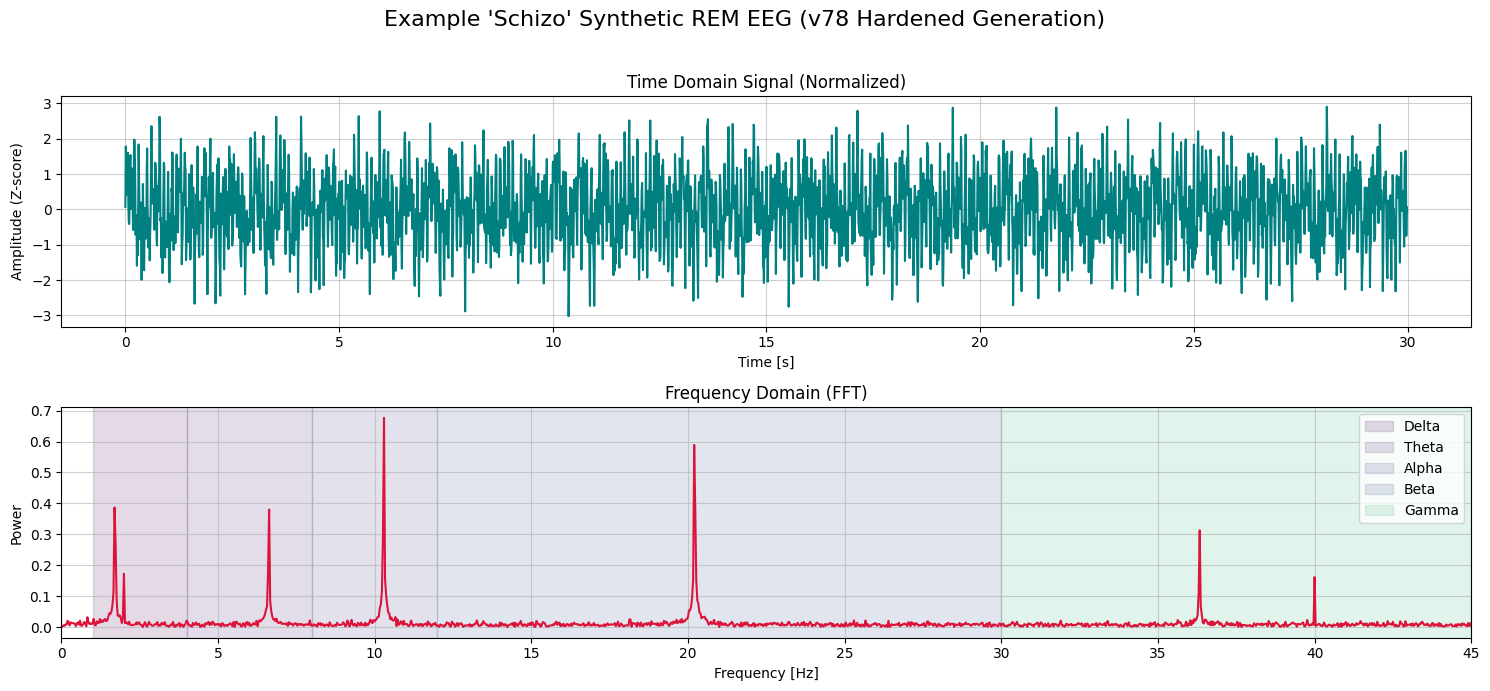

[INFO] [1/4] Generating corrected tabular data for Teacher model...
[INFO] Loading and augmenting tabular data with clearer class separation...
[INFO] Successfully generated 9000 hardened tabular samples.
[INFO] [2/4] Training AutoGluon Teacher model (preset: best_quality)...


2025-08-12 14:07:16,040	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(_dystack pid=27844) C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=27844)   warnings.warn(
(_dystack pid=27844) C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=27844)   warnings.warn(
(_dystack pid=27844) C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` i

[INFO] Teacher model trained.
[INFO] [3/4] Preparing data splits and soft labels for Student...
[INFO] Using ON-THE-FLY data generation for memory efficiency.
[INFO] Detected 22 features per signal.
[INFO] Data split: 7200 train, 1800 val. Ready for Student.
[INFO] [4/4] Training ChimeraNet Student model (Adv Training: True)...


Epoch 1/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 1/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.5685 | Train Acc: 64.40%
Val Loss:   0.5169 | Val Acc:   75.56%
[INFO] New best model! Val Acc: 75.56%. Saving...


Epoch 2/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.5088 | Train Acc: 75.35%
Val Loss:   0.4876 | Val Acc:   79.06%
[INFO] New best model! Val Acc: 79.06%. Saving...


Epoch 3/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4907 | Train Acc: 78.38%
Val Loss:   0.4791 | Val Acc:   80.28%
[INFO] New best model! Val Acc: 80.28%. Saving...


Epoch 4/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4861 | Train Acc: 79.11%
Val Loss:   0.4732 | Val Acc:   79.94%


Epoch 5/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 5/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4776 | Train Acc: 80.50%
Val Loss:   0.4715 | Val Acc:   80.22%


Epoch 6/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 6/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4711 | Train Acc: 81.75%
Val Loss:   0.4577 | Val Acc:   83.89%
[INFO] New best model! Val Acc: 83.89%. Saving...


Epoch 7/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 7/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4664 | Train Acc: 82.36%
Val Loss:   0.4533 | Val Acc:   84.33%
[INFO] New best model! Val Acc: 84.33%. Saving...


Epoch 8/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4635 | Train Acc: 83.47%
Val Loss:   0.4552 | Val Acc:   82.72%


Epoch 9/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 9/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4603 | Train Acc: 83.56%
Val Loss:   0.4535 | Val Acc:   83.50%


Epoch 10/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 10/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4605 | Train Acc: 83.21%
Val Loss:   0.4510 | Val Acc:   84.44%
[INFO] New best model! Val Acc: 84.44%. Saving...


Epoch 11/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 11/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4577 | Train Acc: 83.69%
Val Loss:   0.4481 | Val Acc:   84.17%


Epoch 12/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 12/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4567 | Train Acc: 84.14%
Val Loss:   0.4422 | Val Acc:   85.72%
[INFO] New best model! Val Acc: 85.72%. Saving...


Epoch 13/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 13/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4560 | Train Acc: 83.86%
Val Loss:   0.4419 | Val Acc:   83.94%


Epoch 14/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 14/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4534 | Train Acc: 84.00%
Val Loss:   0.4380 | Val Acc:   85.89%
[INFO] New best model! Val Acc: 85.89%. Saving...


Epoch 15/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 15/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4501 | Train Acc: 84.86%
Val Loss:   0.4354 | Val Acc:   86.44%
[INFO] New best model! Val Acc: 86.44%. Saving...


Epoch 16/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 16/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4495 | Train Acc: 84.15%
Val Loss:   0.4346 | Val Acc:   85.94%


Epoch 17/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 17/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4491 | Train Acc: 84.35%
Val Loss:   0.4399 | Val Acc:   85.17%


Epoch 18/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 18/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4503 | Train Acc: 84.24%
Val Loss:   0.4403 | Val Acc:   84.78%


Epoch 19/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 19/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4461 | Train Acc: 85.06%
Val Loss:   0.4358 | Val Acc:   85.11%


Epoch 20/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 20/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4490 | Train Acc: 84.04%
Val Loss:   0.4285 | Val Acc:   86.44%


Epoch 21/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 21/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4471 | Train Acc: 84.29%
Val Loss:   0.4341 | Val Acc:   85.56%


Epoch 22/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 22/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4469 | Train Acc: 84.32%
Val Loss:   0.4337 | Val Acc:   86.61%
[INFO] New best model! Val Acc: 86.61%. Saving...


Epoch 23/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 23/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4435 | Train Acc: 85.11%
Val Loss:   0.4362 | Val Acc:   85.50%


Epoch 24/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 24/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4440 | Train Acc: 84.60%
Val Loss:   0.4349 | Val Acc:   85.06%


Epoch 25/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 25/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4462 | Train Acc: 84.22%
Val Loss:   0.4328 | Val Acc:   85.44%


Epoch 26/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 26/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4444 | Train Acc: 84.38%
Val Loss:   0.4349 | Val Acc:   85.11%


Epoch 27/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 27/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4411 | Train Acc: 85.33%
Val Loss:   0.4332 | Val Acc:   85.50%


Epoch 28/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 28/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4435 | Train Acc: 84.96%
Val Loss:   0.4314 | Val Acc:   85.89%


Epoch 29/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 29/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4433 | Train Acc: 84.99%
Val Loss:   0.4338 | Val Acc:   86.22%


Epoch 30/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 30/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4431 | Train Acc: 84.67%
Val Loss:   0.4297 | Val Acc:   86.44%


Epoch 31/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 31/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4406 | Train Acc: 85.46%
Val Loss:   0.4291 | Val Acc:   85.28%


Epoch 32/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 32/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4404 | Train Acc: 85.06%
Val Loss:   0.4334 | Val Acc:   84.78%


Epoch 33/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 33/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4428 | Train Acc: 84.78%
Val Loss:   0.4259 | Val Acc:   86.56%


Epoch 34/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 34/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4430 | Train Acc: 84.86%
Val Loss:   0.4386 | Val Acc:   84.89%


Epoch 35/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 35/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4399 | Train Acc: 85.03%
Val Loss:   0.4353 | Val Acc:   84.06%


Epoch 36/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 36/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4412 | Train Acc: 84.92%
Val Loss:   0.4263 | Val Acc:   86.28%


Epoch 37/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 37/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4424 | Train Acc: 84.93%
Val Loss:   0.4308 | Val Acc:   86.72%
[INFO] New best model! Val Acc: 86.72%. Saving...


Epoch 38/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 38/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4389 | Train Acc: 85.28%
Val Loss:   0.4266 | Val Acc:   86.61%


Epoch 39/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 39/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4429 | Train Acc: 84.81%
Val Loss:   0.4287 | Val Acc:   85.83%


Epoch 40/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 40/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4408 | Train Acc: 84.67%
Val Loss:   0.4277 | Val Acc:   86.00%


Epoch 41/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 41/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4413 | Train Acc: 85.15%
Val Loss:   0.4285 | Val Acc:   86.28%


Epoch 42/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 42/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4430 | Train Acc: 84.72%
Val Loss:   0.4256 | Val Acc:   86.94%
[INFO] New best model! Val Acc: 86.94%. Saving...


Epoch 43/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 43/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4367 | Train Acc: 85.42%
Val Loss:   0.4389 | Val Acc:   84.83%


Epoch 44/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 44/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4404 | Train Acc: 85.03%
Val Loss:   0.4252 | Val Acc:   85.72%


Epoch 45/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 45/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4389 | Train Acc: 85.39%
Val Loss:   0.4325 | Val Acc:   84.61%


Epoch 46/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 46/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4389 | Train Acc: 85.43%
Val Loss:   0.4305 | Val Acc:   85.61%


Epoch 47/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 47/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4413 | Train Acc: 84.69%
Val Loss:   0.4285 | Val Acc:   85.39%


Epoch 48/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 48/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4384 | Train Acc: 85.51%
Val Loss:   0.4270 | Val Acc:   86.28%


Epoch 49/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 49/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4384 | Train Acc: 85.33%
Val Loss:   0.4315 | Val Acc:   85.83%


Epoch 50/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 50/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4380 | Train Acc: 85.46%
Val Loss:   0.4268 | Val Acc:   85.11%


Epoch 51/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 51/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4402 | Train Acc: 84.74%
Val Loss:   0.4283 | Val Acc:   86.00%


Epoch 52/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 52/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4374 | Train Acc: 85.32%
Val Loss:   0.4380 | Val Acc:   84.67%


Epoch 53/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 53/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4391 | Train Acc: 85.79%
Val Loss:   0.4237 | Val Acc:   86.72%


Epoch 54/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 54/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4343 | Train Acc: 86.22%
Val Loss:   0.4307 | Val Acc:   85.61%


Epoch 55/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 55/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4403 | Train Acc: 84.83%
Val Loss:   0.4232 | Val Acc:   86.39%


Epoch 56/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 56/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4392 | Train Acc: 85.18%
Val Loss:   0.4314 | Val Acc:   86.06%


Epoch 57/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 57/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4363 | Train Acc: 85.92%
Val Loss:   0.4215 | Val Acc:   87.33%
[INFO] New best model! Val Acc: 87.33%. Saving...


Epoch 58/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 58/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4377 | Train Acc: 85.42%
Val Loss:   0.4246 | Val Acc:   86.17%


Epoch 59/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 59/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4434 | Train Acc: 84.26%
Val Loss:   0.4322 | Val Acc:   85.11%


Epoch 60/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 60/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4383 | Train Acc: 85.11%
Val Loss:   0.4266 | Val Acc:   86.78%


Epoch 61/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 61/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4401 | Train Acc: 85.31%
Val Loss:   0.4308 | Val Acc:   86.22%


Epoch 62/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 62/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4400 | Train Acc: 84.92%
Val Loss:   0.4233 | Val Acc:   86.44%


Epoch 63/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 63/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4383 | Train Acc: 85.43%
Val Loss:   0.4350 | Val Acc:   85.56%


Epoch 64/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 64/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4351 | Train Acc: 85.71%
Val Loss:   0.4276 | Val Acc:   85.50%


Epoch 65/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 65/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4385 | Train Acc: 85.08%
Val Loss:   0.4233 | Val Acc:   86.94%


Epoch 66/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 66/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4404 | Train Acc: 85.14%
Val Loss:   0.4255 | Val Acc:   86.94%


Epoch 67/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 67/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4342 | Train Acc: 86.08%
Val Loss:   0.4228 | Val Acc:   86.67%


Epoch 68/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 68/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4377 | Train Acc: 85.53%
Val Loss:   0.4289 | Val Acc:   86.06%


Epoch 69/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 69/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4356 | Train Acc: 85.61%
Val Loss:   0.4241 | Val Acc:   86.61%


Epoch 70/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 70/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4375 | Train Acc: 85.25%
Val Loss:   0.4274 | Val Acc:   85.89%


Epoch 71/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 71/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4397 | Train Acc: 85.33%
Val Loss:   0.4243 | Val Acc:   86.72%


Epoch 72/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 72/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4370 | Train Acc: 85.74%
Val Loss:   0.4277 | Val Acc:   85.44%


Epoch 73/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 73/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4391 | Train Acc: 85.21%
Val Loss:   0.4289 | Val Acc:   86.61%


Epoch 74/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 74/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4371 | Train Acc: 85.56%
Val Loss:   0.4261 | Val Acc:   86.61%


Epoch 75/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 75/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4359 | Train Acc: 85.81%
Val Loss:   0.4304 | Val Acc:   86.00%


Epoch 76/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 76/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4365 | Train Acc: 85.71%
Val Loss:   0.4187 | Val Acc:   87.50%
[INFO] New best model! Val Acc: 87.50%. Saving...


Epoch 77/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 77/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4374 | Train Acc: 85.83%
Val Loss:   0.4282 | Val Acc:   86.56%


Epoch 78/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 78/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4364 | Train Acc: 86.01%
Val Loss:   0.4248 | Val Acc:   86.83%


Epoch 79/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 79/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4368 | Train Acc: 85.56%
Val Loss:   0.4282 | Val Acc:   85.83%


Epoch 80/80 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 80/80 [Val]  :   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.4387 | Train Acc: 85.31%
Val Loss:   0.4278 | Val Acc:   86.94%
[INFO] Training finished.
[INFO] Distillation pipeline completed successfully.

Options:
 1. Run full DISTILLATION pipeline
 2. Demonstrate trained model
 3. Fine-tune on REAL EEG data
 4. Exit
[INFO] Demonstrating model on newly generated signals...
[INFO] Loading and augmenting tabular data with clearer class separation...
[INFO] Successfully generated 9000 hardened tabular samples.

--- Clinical Signal Demonstration (v79) ---

True: healthy  | Predicted: healthy  | ✅ Correct
True: ptsd     | Predicted: ptsd     | ✅ Correct
True: schizo   | Predicted: schizo   | ✅ Correct



Options:
 1. Run full DISTILLATION pipeline
 2. Demonstrate trained model
 3. Fine-tune on REAL EEG data
 4. Exit
Exiting...


In [8]:
# Block 8: Start the main interactive menu
if __name__ == "__main__":
    run_menu()